In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [2]:
btc=pd.read_csv("BTC-USD.csv")
btc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-04-01,1071.709961,1091.719971,1061.089966,1080.500000,1080.500000,289633984
1,2017-04-02,1080.609985,1107.589966,1075.449951,1102.170044,1102.170044,514187008
2,2017-04-03,1102.949951,1151.739990,1102.949951,1143.810059,1143.810059,580444032
3,2017-04-04,1145.520020,1156.439941,1120.520020,1133.250000,1133.250000,436310016
4,2017-04-05,1134.140015,1135.089966,1113.630005,1124.780029,1124.780029,414784000


In [3]:
btc["Date"]=pd.to_datetime(btc["Date"], format="%Y-%m-%d")
btc.set_index("Date", inplace=True)

In [4]:
df = btc.filter(['Close'])

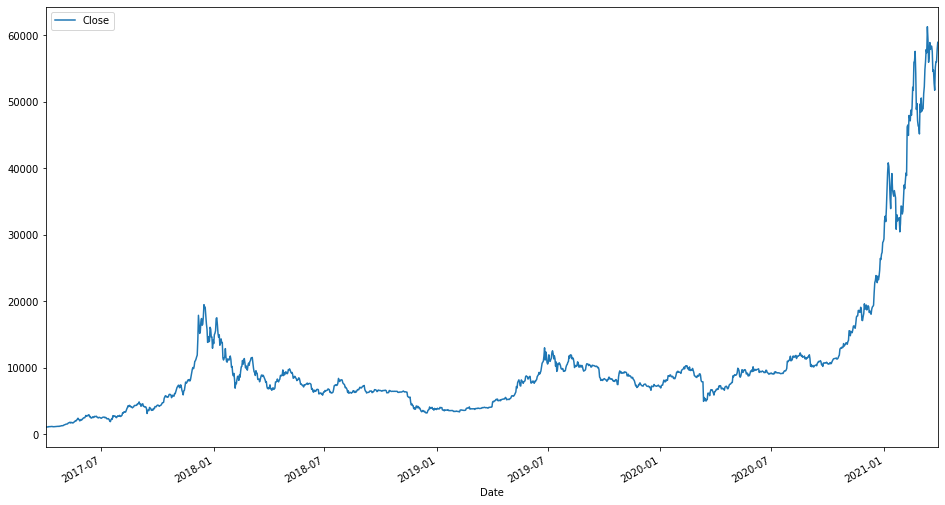

In [5]:
df.plot(figsize=(16,9))

In [6]:
data = df.values
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled= scaler.fit_transform(data)

In [7]:
period=180
train = scaled[1:len(data)-period+1,:]
test = scaled[len(train)-90 : , : ]
x_train=[]
y_train =[]
x_test = []
y_test =  data[len(train) : , : ]
for i in range(90,len(train)):
    x_train.append(train[i-90:i,0])
    y_train.append(train[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
for i in range(90,len(test)):
    x_test.append(test[i-90:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [8]:
rnn = Sequential()
rnn.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
rnn.add(LSTM(units=20, return_sequences=False))
rnn.add(Dense(units=20))
rnn.add(Dense(units=1))

In [9]:
rnn.compile(optimizer='adam', loss='mean_squared_error')
rnn.fit(x_train, y_train, batch_size=1, epochs=1)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1





1187/1187 [==============================] - 737s 621ms/step - loss: 4.1703e-04


In [10]:
predictions = rnn.predict(x_test) 
predictions = scaler.inverse_transform(predictions)

In [11]:
compare=df[len(train):]
compare['Predictions']=predictions
compare = compare.rename(columns={'Close': 'Actual'})

C:\Users\m\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


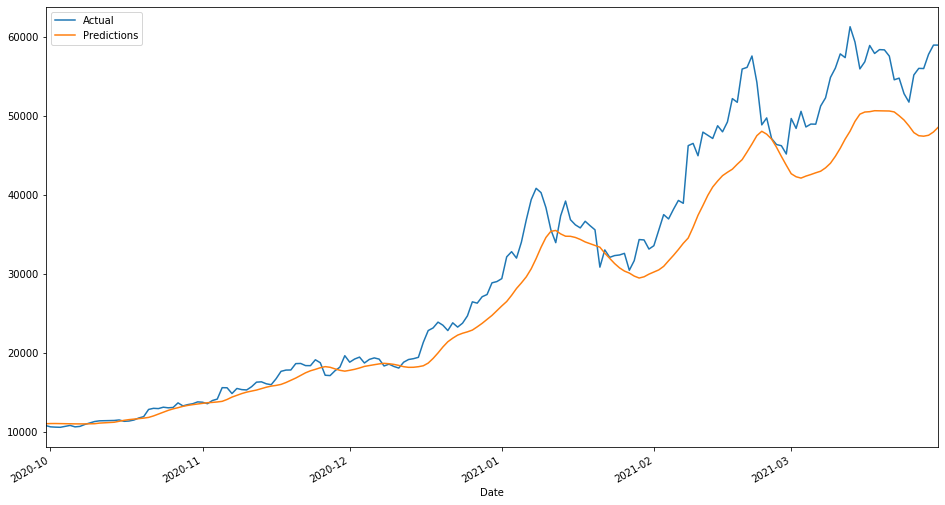

In [12]:
compare.plot(figsize=(16,9))

In [13]:
rmse=((compare['Predictions']-compare['Actual'])**2).mean()**0.5
rmse

4847.65874754112

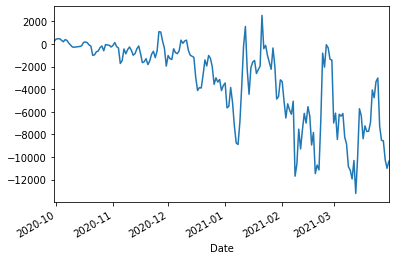

In [14]:
compare['Resid']=compare['Predictions']-compare['Actual']
compare['Resid'].plot()

Different Hyperparameters | Multivariate